In [1]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize, TweetTokenizer, WhitespaceTokenizer, RegexpTokenizer
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
data = pd.read_csv('train_en.txt', sep='\t')

In [4]:
val_data = pd.read_csv('val_en.txt',sep='\t')
test_data = pd.read_csv('test_en.txt',sep='\t')

In [5]:
data

,Sentence,Style
0,he had steel balls too !,toxic
1,"dude should have been taken to api , he would ...",toxic
2,"im not gonna sell the fucking picture , i just...",toxic
3,the garbage that is being created by cnn and o...,toxic
4,the reason they dont exist is because neither ...,toxic
...,...,...
25035,both sides need to calm down or we are heading...,neutral
25036,i 'm sitting here in my calm german city conte...,neutral
25037,"dude , get a clue .",neutral
25038,"I was so high, it was amazing.",neutral


In [6]:
data['Tokens'] = data['Sentence'].apply(lambda x: word_tokenize(x.lower()))

In [7]:
val_data['Tokens'] = val_data['Sentence'].apply(lambda x: word_tokenize(x.lower()))
test_data['Tokens'] = test_data['Sentence'].apply(lambda x: word_tokenize(x.lower()))

In [8]:
data

,Sentence,Style,Tokens
0,he had steel balls too !,toxic,"[he, had, steel, balls, too, !]"
1,"dude should have been taken to api , he would ...",toxic,"[dude, should, have, been, taken, to, api, ,, ..."
2,"im not gonna sell the fucking picture , i just...",toxic,"[im, not, gon, na, sell, the, fucking, picture..."
3,the garbage that is being created by cnn and o...,toxic,"[the, garbage, that, is, being, created, by, c..."
4,the reason they dont exist is because neither ...,toxic,"[the, reason, they, dont, exist, is, because, ..."
...,...,...,...
25035,both sides need to calm down or we are heading...,neutral,"[both, sides, need, to, calm, down, or, we, ar..."
25036,i 'm sitting here in my calm german city conte...,neutral,"[i, 'm, sitting, here, in, my, calm, german, c..."
25037,"dude , get a clue .",neutral,"[dude, ,, get, a, clue, .]"
25038,"I was so high, it was amazing.",neutral,"[i, was, so, high, ,, it, was, amazing, .]"


In [9]:
sentences = data['Tokens'].values

In [10]:
sentences

array([list(['he', 'had', 'steel', 'balls', 'too', '!']),
       list(['dude', 'should', 'have', 'been', 'taken', 'to', 'api', ',', 'he', 'would', 'be', 'right', 'at', 'home', 'with', 'all', 'the', 'other', 'knuckleheads', 'there']),
       list(['im', 'not', 'gon', 'na', 'sell', 'the', 'fucking', 'picture', ',', 'i', 'just', 'want', 'to', 'contribute', 'to', 'the', 'fucking', 'article', '.']),
       ..., list(['dude', ',', 'get', 'a', 'clue', '.']),
       list(['i', 'was', 'so', 'high', ',', 'it', 'was', 'amazing', '.']),
       list(['pay', 'your', 'bills', '.'])], dtype=object)

In [11]:
val_sentences = val_data['Tokens'].values

In [12]:
val_labels=val_data['Style']

In [13]:
val_sentences

array([list(['honestly', 'catcalling', 'really', 'sounds', 'stupid', '.']),
       list(['the', 'police', 'dont', 'have', 'time', 'for', 'this', 'crap', '.']),
       list(['if', 'any', 'of', 'the', 'cry', 'babies', 'who', 'dont', 'respect', 'democracy', 'come', ',', 'it', 'will', 'be', 'the', 'stupid', 'drain']),
       ..., list(['he', 'is', 'a', 'junior', 'senator', '.']),
       list(['you', 'got', 'ta', 'inject', 'that']),
       list(['hamas', 'is', 'winning', 'this', 'battle', 'despite', 'the', 'gazan', 'death', 'toll', 'because', 'hamas', 'does', "n't", 'care', 'about', 'gazans'])],
      dtype=object)

In [14]:
model_word2vec = Word2Vec(sentences, vector_size=50, min_count=15, sg=1)

In [15]:
words = model_word2vec.wv.index_to_key

In [16]:
words.append('<UNK>')

In [17]:
word_embeddings = model_word2vec.wv.vectors

In [18]:
word_embeddings.shape

(1459, 50)

In [19]:
unk = np.random.rand(50)

In [20]:
word_embeddings = np.append(word_embeddings, [unk], axis=0)

In [21]:
len(word_embeddings)

1460

In [22]:
tsne = TSNE(n_components=2, random_state=0, )

In [23]:
word_embeddings_2d = tsne.fit_transform(word_embeddings[:50])

In [24]:
len(word_embeddings_2d[0])

2

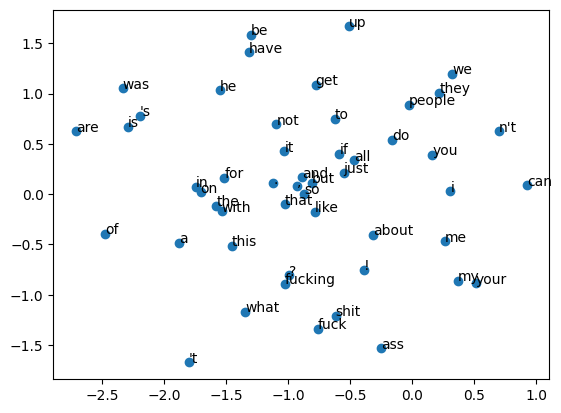

In [25]:
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1])
for label, x, y in zip(words[:50], word_embeddings_2d[:, 0], word_embeddings_2d[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

In [26]:
word_to_id = {word: i for i, word in enumerate(words)}

In [27]:
word_to_id['<UNK>']

1459

In [28]:
len(word_to_id)

1460

In [29]:
data['IDs'] = data['Tokens'].apply(lambda x: [word_to_id[word] if word in word_to_id else word_to_id['<UNK>'] for word in x])

In [30]:
val_data['IDs'] = val_data['Tokens'].apply(
    lambda x: [word_to_id[word] if word in word_to_id else word_to_id['<UNK>'] for word in x]
)

In [31]:
padded_val_ids = pad_sequences(val_data['IDs'].values, maxlen=15)

In [32]:
token_ids = data['IDs'].values

In [33]:
token_ids

array([list([35, 147, 1459, 1273, 92, 12]),
       list([295, 102, 37, 128, 1167, 5, 1459, 3, 35, 60, 29, 86, 62, 321, 33, 45, 1, 155, 1459, 72]),
       list([116, 21, 176, 134, 1459, 1, 23, 1092, 3, 2, 31, 98, 5, 1459, 5, 1, 23, 202, 0]),
       ..., list([295, 3, 41, 6, 646, 0]),
       list([2, 34, 39, 455, 3, 13, 34, 327, 0]),
       list([318, 40, 1459, 0])], dtype=object)

In [34]:
padded_ids = pad_sequences(token_ids, 15)

In [35]:
padded_ids

array([[   0,    0,    0, ..., 1273,   92,   12],
       [   5, 1459,    3, ...,  155, 1459,   72],
       [1459,    1,   23, ...,   23,  202,    0],
       ...,
       [   0,    0,    0, ...,    6,  646,    0],
       [   0,    0,    0, ...,   34,  327,    0],
       [   0,    0,    0, ...,   40, 1459,    0]], dtype=int32)

In [36]:
labels = data['Style'].values

In [37]:
labels

array(['toxic', 'toxic', 'toxic', ..., 'neutral', 'neutral', 'neutral'],
      dtype=object)

In [38]:
model = Sequential()

In [39]:
len(words)

1460

In [40]:
len(word_embeddings)

1460

In [41]:
from sklearn.preprocessing import LabelEncoder
labels_transformer = LabelEncoder().fit(labels)
labels_transformed = labels_transformer.transform(labels)
val_labels_transformed = labels_transformer.transform(val_labels)

In [42]:
model.add(Embedding(input_dim=len(words), output_dim=50,weights=[word_embeddings], trainable=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy')
model.fit(padded_ids, labels_transformed, validation_data=(padded_val_ids, val_labels_transformed))

783/783 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.4154 - val_loss: 0.1963


In [43]:
test_data = pd.read_csv('test_en.txt', sep='\t')


test_data['Tokens'] = test_data['Sentence'].apply(lambda x: word_tokenize(x.lower()))


test_data['IDs'] = test_data['Tokens'].apply(
    lambda x: [word_to_id[word] if word in word_to_id else word_to_id['<UNK>'] for word in x]
)


padded_test_ids = pad_sequences(test_data['IDs'].values, maxlen=15)

predictions = model.predict(padded_test_ids)



98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
test_labels = test_data['Style'].values
test_labels_transformed = labels_transformer.transform(test_labels)

In [51]:
predictions


array([[0.46156734],
       [0.9983816 ],
       [0.74468356],
       ...,
       [0.01331753],
       [0.01492727],
       [0.00502503]], dtype=float32)

In [49]:
predicted_classes = (predictions > 0.5).astype(int)

accuracy = accuracy_score(test_labels_transformed, predicted_classes)
precision = precision_score(test_labels_transformed, predicted_classes)
recall = recall_score(test_labels_transformed, predicted_classes)
f1 = f1_score(test_labels_transformed, predicted_classes)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.92
Precision: 1.00
Recall: 0.85
F1 Score: 0.92
